# Testing Seasonality with Randomeness

We investigate the seasonality of the EWS ETF, following on from the work of [Mitchell Rosenthal](https://twitter.com/M1tchRosenthal/status/1375149026220371970). 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf

## Reproducing original results

Mitch observed that 89% of the time, April had a positive return. We first attempt to replicate this.

In [2]:
df = yf.download("EWS")["Adj Close"]
df.head()

[*********************100%***********************]  1 of 1 completed


Date
1996-03-18    11.301652
1996-03-19    11.414671
1996-03-20    11.301652
1996-03-21    11.301652
1996-03-22    11.527687
Name: Adj Close, dtype: float64

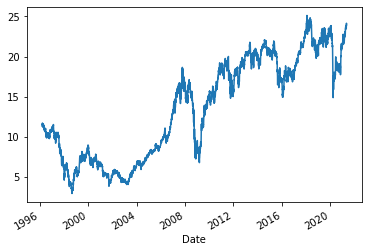

In [3]:
df.plot();

In [4]:
# Reproduce original results
def compute_pct_up_months(df):
    # df is a dataframe of daily close prices
    df_mth = df.resample("M").last()
    month_up = df_mth.pct_change().dropna() > 0
    pct_up = month_up.groupby(month_up.index.month).mean()
    return pct_up

In [5]:
pct_up = compute_pct_up_months(df)
pct_up

Date
1     0.520000
2     0.440000
3     0.640000
4     0.807692
5     0.360000
6     0.560000
7     0.560000
8     0.320000
9     0.560000
10    0.560000
11    0.560000
12    0.680000
Name: Adj Close, dtype: float64

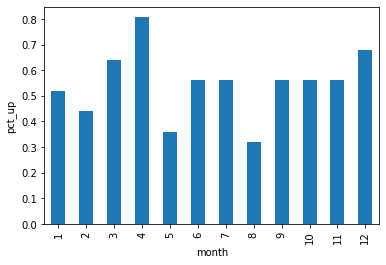

In [6]:
pct_up.plot.bar(xlabel="month", ylabel="pct_up");

Although our numbers are slightly different (expected given a slightly different methodology and more data), the anomaly is replicated.

## Random data

In this section we will compute different paths of history by reshuffling the dataframe. This is a simple way of generating random data with the same mean/volatility over the entire sample period (though obviously different for rolling windows).

This helps us understand if the anomaly is "statistically significant". 

In [7]:
# The value whose significance we are trying to evaluate
threshold_pct = 0.8

In [8]:
rets = df.pct_change().dropna()
rets

Date
1996-03-19    0.010000
1996-03-20   -0.009901
1996-03-21    0.000000
1996-03-22    0.020000
1996-03-25    0.009804
                ...   
2021-04-26    0.006706
2021-04-27    0.001249
2021-04-28    0.004158
2021-04-29   -0.003727
2021-04-30   -0.004987
Name: Adj Close, Length: 6323, dtype: float64

In [9]:
def generate_path(rets):
    ret_shuffled = rets.sample(frac=1)
    ret_shuffled.index = rets.index
    px_new = (1+ret_shuffled).cumprod()
    return px_new

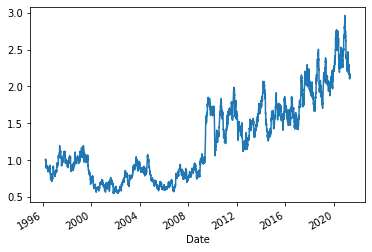

In [10]:
px_new = generate_path(rets)
px_new.plot();

In [11]:
px_new = generate_path(rets)
pct_up = compute_pct_up_months(px_new)
pct_up

Date
1     0.520000
2     0.520000
3     0.440000
4     0.538462
5     0.520000
6     0.480000
7     0.640000
8     0.520000
9     0.680000
10    0.640000
11    0.360000
12    0.560000
Name: Adj Close, dtype: float64

In [12]:
NUM_PATHS = 10000
paths = []

for i in range(NUM_PATHS):
    px = generate_path(rets).rename(i)
    paths.append(px)
paths_df = pd.concat(paths, axis=1)

max_up = compute_pct_up_months(paths_df).max()

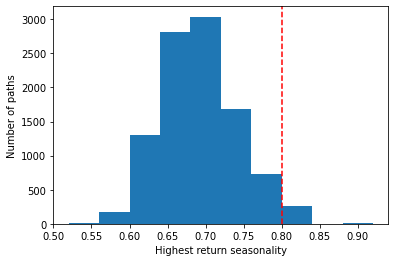

In [13]:
fig, ax = plt.subplots()
max_up.hist(ax=ax, grid=False);
ax.axvline(threshold_pct, color="r", linestyle="--");
ax.set_xlabel("Highest return seasonality")
ax.set_ylabel("Number of paths");

In [14]:
p_val = (max_up > threshold_pct).sum() / NUM_PATHS
p_val

0.0072